This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      215
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:       86

Total number of variables............................:       90
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       40

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1250000e+08 1.76e+02 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

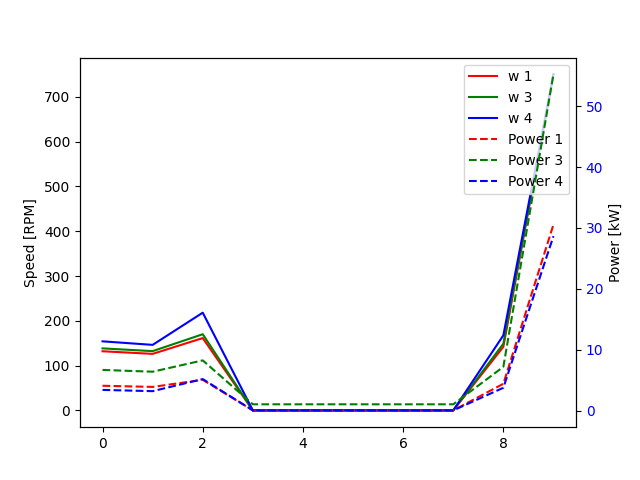

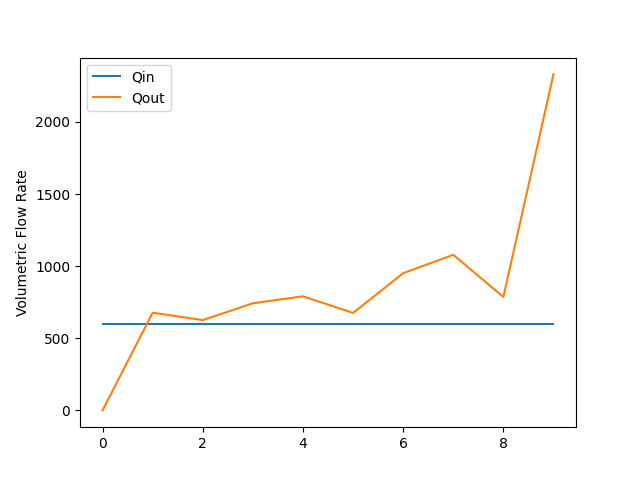

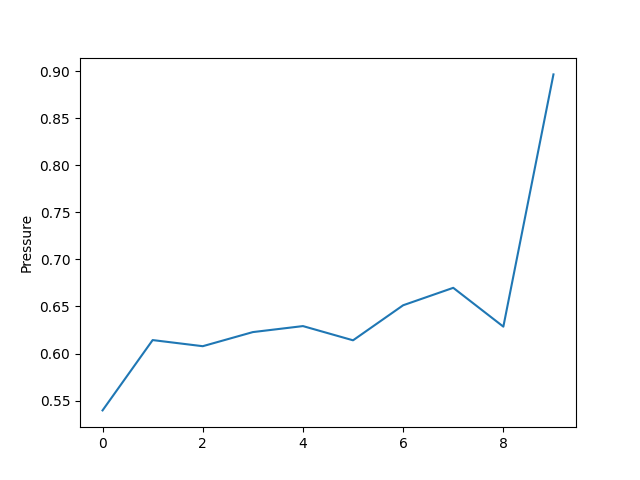

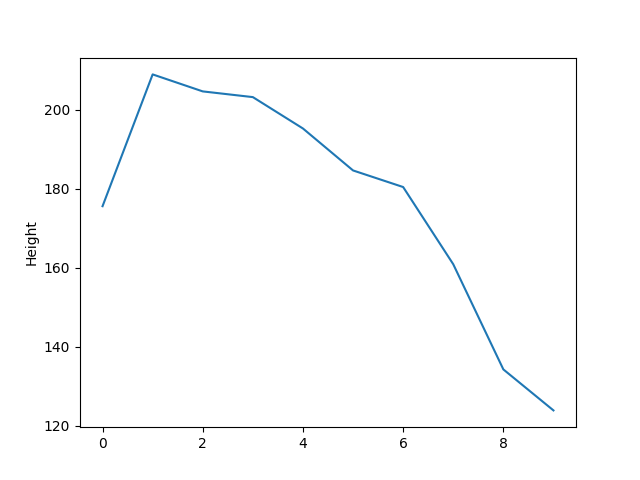

In [41]:
%matplotlib widget
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

plt.close("all")

# Create an Opti instance
opti = ca.Opti()

# Solver options
opts = {
    #"qpsol": "ipopt",
    #"convexify_strategy": "regularize",
    "print_time": 0,
    #"print_iteration": 0,
    #"print_header": 0,
    "verbose": False,
    "error_on_fail": False
}

opti.solver('ipopt',opts)


#=========== Parameters of the static models
B1_power = np.array([[2.8481E-02,0,0],[0,3.3614E-02,0],[0,0,1.7562E-02]])
B2_power = np.array([[1.6230E-05,0,0],[0,5.1395E-05,0],[0,0,2.7402E-05]])
C_power = np.array([[7.4287E-02],[1.0755E+00],[7.6364E-02]])
zs_pwr = 0      # Zero shift power


B1_pressure = np.array([9.2727E-05])
B2_pressure = np.array([2.5979E-08])
C_pressure = np.array([5.3955E-01])
zs_pr = 0       # Zero shift power

#=========== Parameters of the ARX model
# array of params
A_outflow = np.array([-1.2312E-03,1.5751E-02,1.4445E-03,-1.4182E-02,1.7257E-03,-1.5083E-02,1.3046E-01,-9.8236E-04,1.8656E-02,1.9622E-02]).reshape((1,-1))
zs_oflw = 3     # Zero shift outflow
zs_w = 2     # Zero shift speed

#=========== Parameters of the ARX model
#A (ny x (na1+na2)) na1,2: lags on y1,2
# A_power = np.array([[8.6870E-01,0],[0,8.7838E-01]])
# A_outflow = np.array([[1.0869,-1.5832E-01]])

# B (ny x (nb1+nb2)) nb1,2: lags on u1,2
# B_power = np.array([[2.7560E-02,0,-2.2282E-02,0],[0,3.5775E-02,0,-3.0685E-02]])
# B_outflow = np.array([[4.2454E-01,6.6812E-01,-3.6354E-01,-3.6354E-01]])

# C_power = np.array([1.0790E-02,1.7240E-02])
# C_outflow = np.array([-1.5832E-01])

#=========== Desired value of y 
Qout_meas = opti.parameter(3)   # ascending index: older data, at 0: last measured value (t-1)
Qin_est = opti.parameter()
Qin_meas= opti.parameter(1)     # "historic estimate"
w_meas =  opti.parameter(3,3)   #TODO: Remove hard-coded Dims
h_meas = opti.parameter()
E_meas = opti.parameter(3)
P_meas = opti.parameter()

#=========== Define the Horizon
N = 10

#=========== Declare Symbolic Variables (SISO but can be extended to MIMO or MISO)
Qout = opti.variable(N)
Qin = opti.variable(N)
E = opti.variable(3,N)
P = opti.variable(N)
w = opti.variable(3,N)
h = opti.variable(N)
Qin[:] = Qin_est


#=========== Objective function
# Minimize the deviation of y from yd and control effort
objective = 0
for t in range(0, N):
    # objective += 5*((E[0,t]+E[1,t]+E[2,t])/(Qout[t]+1))**2 + 0.5*(w[0,t]+w[1,t]+w[2,t])**2
    # objective += 5*((E[0,t]+E[1,t]+E[2,t])/(Qout[t]+1))**2# + 0.5*(w[0,t]+w[1,t]+w[2,t])**2
    objective += 500*(h[t]-150)**2 #+ 0.1*w[:,t].T @ w[:,t]
  

opti.minimize(objective)

# ARX model constraints
opti.subject_to(Qout[0] == A_outflow @ ca.vcat([Qout_meas[2],w_meas[2,0]**2, w_meas[2,0]*Qout[t-3], w_meas[2,0]*w_meas[0,0],Qout_meas[2]**2, 
                                                    w_meas[2,0]*w_meas[1,0], w_meas[2,0], w_meas[1,0]*w_meas[0,0], w_meas[1,0]**2, w_meas[0,0]**2]))
opti.subject_to(Qout[1] == A_outflow @ ca.vcat([Qout_meas[1],w[2,0]**2, w[2,0]*Qout[t-3], w[2,0]*w[0,0],Qout_meas[1]**2, 
                                                w[2,0]*w[1,0], w[2,0], w[1,0]*w[0,0], w[1,0]**2, w[0,0]**2]))
opti.subject_to(Qout[2] == A_outflow @ ca.vcat([Qout_meas[0],w[2,1]**2, w[2,1]*Qout[t-3], w[2,1]*w[0,1],Qout_meas[0]**2, 
                                                w[2,1]*w[1,1], w[2,1], w[1,1]*w[0,1], w[1,1]**2, w[0,1]**2]))
for t in range(zs_oflw, N):   
    opti.subject_to(Qout[t] == A_outflow @ ca.vcat([Qout[t-3],w[2,t-1]**2, w[2,t-1]*Qout[t-3], w[2,t-1]*w[0,t-1],Qout[t-3]**2, 
                                            w[2,t-1]*w[1,t-1], w[2,t-1], w[1,t-1]*w[0,t-1], w[1,t-1]**2, w[0,t-1]**2]))
    
for t in range(0, N):
    opti.subject_to(E[:,t] == B1_power @ w[:,t] + B2_power @ w[:,t]**2 + C_power)
    opti.subject_to(P[t] == B1_pressure @ Qout[t] + B2_pressure @ Qout[t]**2 + C_pressure)

Ts = 1      
A = 18

opti.subject_to(h[0] == h_meas[0] + Ts/A*(Qin_meas[0]-Qout_meas[0]))
for t in range(1, N):    
    opti.subject_to(h[t] == h[t-1] + Ts/A*(Qin[t-1]-Qout[t-1]))

# Additional constraints (e.g., on control input)
for t in range(N):
    opti.subject_to(w[:,t] >= 0)  # Lower bound on control input
    opti.subject_to(w[:,t] <= 1500)   # Upper bound on control input
    opti.subject_to(h[t] >= 120)  # Lower bound on control input
    # opti.subject_to(h[t] <= 200)   # Upper bound on control input
    opti.subject_to(P[t] <= 1)  # upper bound on pressure




# Initial conditions
# opti.subject_to(Qout[0:2]   == Qout_meas)  # Initial value of y, read from sensor
# opti.subject_to(h[0]        == h_meas)
# opti.subject_to(w[:,0]      == w_meas[:,0])    #TODO: Doublecheck assignment here
# opti.subject_to(w[:,1]      == w_meas[:,1])
# opti.subject_to(w[:,2]      == w_meas[:,2])
# opti.subject_to(E[:,0]      == E_meas[:,0])    #TODO: Doublecheck assignment here
# opti.subject_to(P[0]      == P_meas)
    



for i in range(1):   
    # Update the following values:
    # - Qin_est
    # - Qout_meas
    # - E_meas
    # - P_meas
    # - w_meas
    # - h_meas

    opti.set_value(Qin_est,600)
    opti.set_value(Qin_meas,100)
    opti.set_value(Qout_meas,[0,0,0])
    opti.set_value(h_meas,170)
    opti.set_value(w_meas,ca.hcat([[0,0,0],[0,0,0],[0,0,0]])) 
    opti.set_value(E_meas,[0,0,0])
    opti.set_value(P_meas,0.5)


    sol = opti.solve();   # actual solve


plt.clf()    
ax1 = plt.subplot(1,1,1)
plt.plot(sol.value(w)[0,:],"r",label='w 1')
plt.plot(sol.value(w)[1,:],"g",label='w 3')
plt.plot(sol.value(w)[2,:],"b",label='w 4')
plt.ylabel('Speed [RPM]')
ax12 = ax1.twinx()
ax12.plot(sol.value(E)[0,:],"r--",label='Power 1')
ax12.plot(sol.value(E)[1,:],"g--",label='Power 3')
ax12.plot(sol.value(E)[2,:],"b--",label='Power 4')
ax12.set_ylabel('Power [kW]')
ax12.tick_params(axis ='y', labelcolor = 'blue')
h1, l1 = ax1.get_legend_handles_labels()
h12, l12 = ax12.get_legend_handles_labels()
ax1.legend(h1+h12, l1+l12, loc=1) 
plt.show()

plt.figure()
plt.plot(sol.value(h),label='h')
plt.ylabel("Height")
plt.figure()
plt.plot(sol.value(Qin),label='Qin')
plt.plot(sol.value(Qout),label='Qout')
plt.ylabel("Volumetric Flow Rate")
plt.legend()
plt.show()

plt.figure()
plt.plot(sol.value(P),label='P')
plt.ylabel("Pressure")
plt.show()

